## Описание проекта

Построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Описание данных

Данные взяты с сайта ChaLearn Looking at People http://chalearnlap.cvc.uab.es/dataset/26/description/.

В вашем распоряжении одна папка со всеми изображениями `/final_files` и csv-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.

Где еще можно взять данные:           
Загрузка датасета с Kaggle https://www.kaggle.com/abhikjha/appa-real-face-cropped

## План работы
1. Исследование данных
2. Обучение модели
3. Анализ результатов

### библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# 1. Исследовательский анализ данных

In [3]:
df = read_csv('labels.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


посмотрим на распеределение возраста

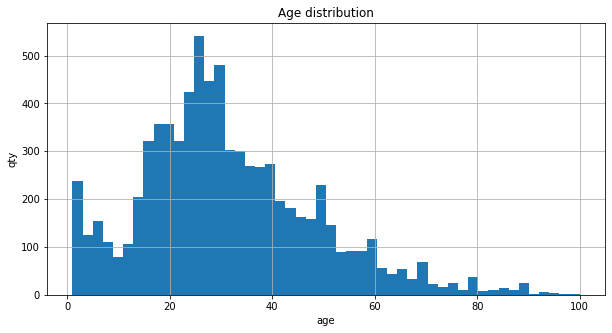

In [8]:
plt.figure(figsize=(10,5))
plt.xlabel('age')
plt.ylabel('qty')
plt.title('Age distribution')

df['real_age'].hist(bins=50)

Распределение возрастов покоже на нормальное, скошенное влево. В выборке есть пик с возрастом менее 5 лет, что не нужно для выполнения поставленной задачи. Так же есть недостаток фото людей пожилого возраста, значит сеть будет менее точна на этой группе.

загрузим фото

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    seed=12345)

Found 7073 validated image filenames.


In [8]:
features, target = next(datagen_flow)

посмотрим первые 15 фото

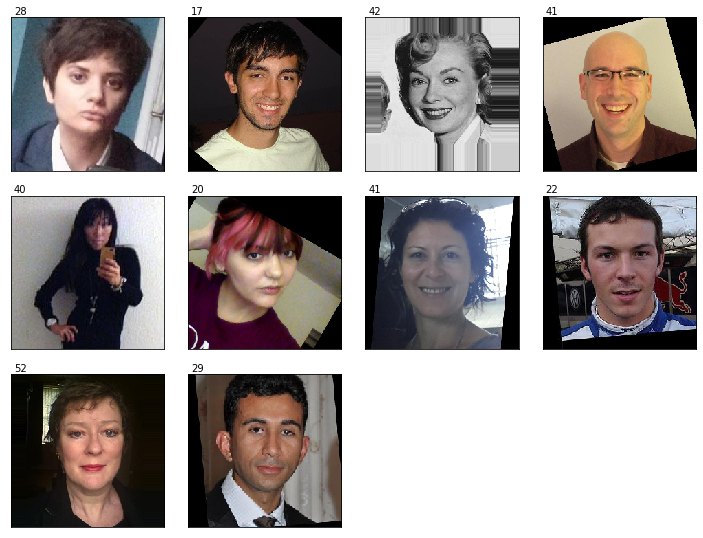

In [9]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.text(4, -4, target[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод:
Фото имеют разный фон, поворот лица, освещение и качество изображениея. На одном из фото был ошибочно определен возраст, из-за плохого качества изображения.

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
 
labels = pd.read_csv('/datasets/faces/labels.csv')
 
 
def load_train(path):
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        validation_split=0.25,
        rescale=1/255.)
 
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    valid_datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return train_datagen_flow, valid_datagen_flow


 
 
def load_test(path):
    datagen = ImageDataGenerator(
        rescale=1/255.)
 
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
 
    return test_datagen_flow    
 
 
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
 
    backbone = ResNet50(input_shape=input_shape,
        weights='imagenet',
        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
 
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model
```

# 3. Анализ обученной модели

На тестовой выборке минимальный mae 3.15, что лучше поставленного задачей.    
Что еще можно было бы попробовать для улучшения качества:
- добавить фото людей старше 40 лет
- убрать фото детей младше 7 лет (для поставленных задач - эти данные не нужны)
- перевести все фото в ч/б
- убрать все изображения плохого качества (в одном из фото реальный возраст не совпадал с целевым признаком)
- часть фото обрезать до портрета